# Data Uniformity in Data Science
## Treating most common uniformity problems in Pandas
<img src='images/crowd.jpg'></img>
<figcaption style="text-align: center;">
    <strong>
        Image by 
        <a href='https://pixabay.com/users/mwewering-185784/?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=1699137'>Matthias Wewering</a>
        on 
        <a href='https://pixabay.com/?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=1699137'>Pixabay</a>
    </strong>
</figcaption>

### Introduction <small id='intro'></small>

In my previous articles on data cleaning, I talked how out of range values, incorrect data types, uniqueness constraints are common problems and that when left untouched can seriously compromise our analysis. 

In this article, we are going to tackle a problem that is just as dangerous and that can similarly skew our analysis which is **unit uniformity**. 

Problems related to uniformity can come in many shapes:
- temperature data given in both Fahrenheit and Celsius
- weight given in both kilograms and pounds
- multiple date formats
- money represented in different currencies

Such problems arise because of many reasons. For example, data is collected across many locations and merged together into one. This can result in the above problems. It is imperative that you know how to handle uniformity problems for accurate analysis.

### Overview
1. [Introduction](#intro)
1. [Setup](#setup)
1. [Unit Uniformity](#unit)
1. [Date Uniformity](#date)

### Setup <small id='setup'></small>

In [1]:
# Load necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
temperatures = pd.read_csv('data/unit_uniformity.csv', parse_dates=['date'])
people = pd.read_csv('data/date_uniformity.csv')

In [3]:
temperatures.head()

,avg_temperature,date
0,13,2020-09-01
1,16,2020-09-02
2,17,2020-09-03
3,10,2020-09-04
4,12,2020-09-05


In [4]:
people.head()

,first_name,last_name,birthday
0,Desirae,Fry,1975-12-13 00:00:00
1,Jon,Reese,2018-05-30 00:00:00
2,Ivor,Cooper,1967-04-01 00:00:00
3,Mary,Palmer,1984-10-20 00:00:00
4,Cole,Bloom,1999-06-20 00:00:00


### Unit Uniformity <small id='unit'></small>

Consider this temperature dataset imported earlier. It gives information about daily average temperatures for 3 months in Celsius:

In [5]:
temperatures.sample(10)

,avg_temperature,date
82,12,2020-11-22
15,58,2020-09-16
51,14,2020-10-22
6,16,2020-09-07
38,17,2020-10-09
32,19,2020-10-03
72,10,2020-11-12
11,12,2020-09-12
45,59,2020-10-16
3,10,2020-09-04


If we look at index 48, unless a major climate event occurred, we can guess that values is given in Fahrenheit:
<img src='images/1.png'></img>

When you are in such situations, use a scatter plot to spot them visually:

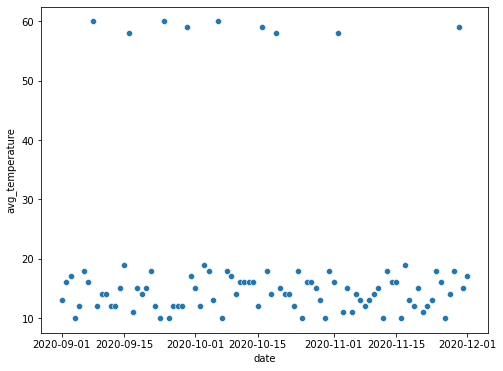

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x='date', y='avg_temperature', data=temperatures);

A scatter plot clearly shows the values which are Fahrenheit. A quick Google search shows us the formula for converting Fahrenheit to Celsius:
<img src='images/2.png'></img>

Now, we will use this equation to convert any values over 40 to Celsius:

In [7]:
# Filter out fahrenheits as a series
temp_fahr = temperatures.loc[temperatures['avg_temperature'] > 40, 'avg_temperature']
# Convert to celsius
temp_celsius = (temp_fahr - 32) * (5/9)
# Replace fahrenheit with celsius
temperatures.loc[temperatures['avg_temperature'] > 40, 'avg_temperature'] = temp_celsius

We can check that the conversion is successful in 2 ways. First, with `assert` statement:

In [8]:
assert temperatures['avg_temperature'].max() <= 40 # if true, no output

Again using a scatter plot:

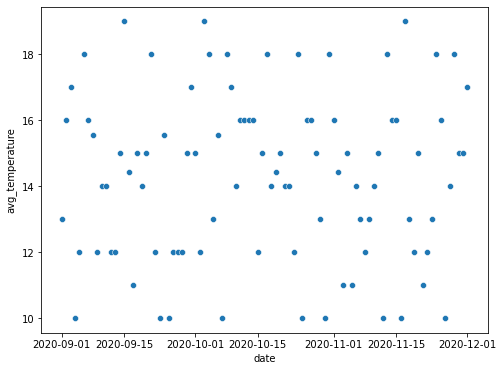

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x='date', y='avg_temperature', data=temperatures);

Even though this was a simple example, your case may be completely different. Sometimes, you might not even notice the inconsistencies in the sea of data. Before looking for them, it is essential that you completely understand your data and learn how it was collected.

### Date Uniformity <small id='date'></small>

One other very common problem is date uniformity. Different countries have different standard date formats and when you have data from multiple sources, you are going to have deal with multiple date formats. In Python, there are 3 main datetime formats you can work with:
- 25-12-2019 -> **(%d-%m-%Y)** -> day, month, year
- October 31, 2020 -> **(%c)** -> literal dates
- 12-25-2019 -> **(%m-%d-%Y)** -> month, day, year

When you load data into your environment with `pandas`, it always imports dates as `object` data type. In the Setup section, we imported a sample data containing people's full name and birthday:

In [10]:
people.sample(5)

,first_name,last_name,birthday
151,Alex,Cooper,1985-06-11 00:00:00
430,Abdul,Pierce,1983-08-30 00:00:00
663,Desirae,Palmer,1993-08-20 00:00:00
856,Mary,Smith,1985-07-11 00:00:00
993,Abdul,Colon,1975-09-13 00:00:00


In [11]:
people.dtypes

first_name    object
last_name     object
birthday      object
dtype: object

The `birthday` column represents the dates as YY-MM-DD format but as strings. Converting date columns to `datetime` has a number of advantages to perform analysis on. We will use `pd.to_datetime()` function to convert the column into `datetime`:

In [12]:
people['birthday'] = pd.to_datetime(people['birthday'])

ParserError: month must be in 1..12: 1960-24-01

We got an error! If we look closer, the error says that month must be in 1, 2, ..., 12. That means, somewhere in the data, there is an inconsistent value that is preventing the function to run. `pd.to_datetime` has a good workaround for such cases:

In [13]:
people['birthday'] = pd.to_datetime(people['birthday'],
                                    # attempt to infer format of each date
                                    infer_datetime_format=True,
                                    # return NA for rows where conversion failed
                                    errors='coerce')

This time, we did not get any error. If you set `infer_datetime_format` to `True`, `pandas` will automatically identify the date format based on the first non-NaN element and converts the rest to that format. If there are any values that do not fit the conversion, `errors` parameter decides what to do with them. If set to `coerce`, `pandas` will put `NaT`s which are missing values for dates. 

Based on our assumptions, the above line of code should have spotted date inconsistencies and put `NaT`s to inconsistent dates:

In [14]:
sum(people['birthday'].isna())

19

There are a few methods to handle such inconsistencies:
- convert to NA and treat accordingly
- infer format by looking at the data source, how it was collected
- infer format by looking at other dates

If you have many inconsistencies, converting them to `NaN` is not always an option. You should try to come up with custom solutions by looking at their patterns and inferring their formats.

After you are done with error-handling and conversions, it is best practice to convert date columns to global DateTime standard:

In [15]:
people['birthday'] = people['birthday'].dt.strftime('%Y-%m-%d')
people.sample(5)

,first_name,last_name,birthday
633,Desirae,Colon,1972-05-20
603,Jon,Palmer,2017-05-07
99,Alex,Cooper,1985-10-27
749,Lane,Smith,2015-08-25
86,Roary,Gibson,1978-05-07
